In [24]:
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from sklearn.metrics import classification_report

In [44]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      #transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      #transforms.functional.rgb_to_grayscale,
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     #transforms.RandomResizedCrop(224),
                                     #transforms.functional.rgb_to_grayscale,
                                     transforms.ToTensor()])


train_data = datasets.ImageFolder('/home/farah.alharthi/ml_lab/project/train_', transform=train_transforms)
test_data = datasets.ImageFolder('/home/farah.alharthi/ml_lab/project/test_', transform=test_transforms)

trainset = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testset = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

In [45]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*128*128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)

model = NeuralNetwork()

In [46]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 3
for epoch in range(EPOCHS):
    for data in trainset:
        X, y = data
        model.zero_grad()
        # to reset the gradients of model parameters;
        # gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
        output = model(X.view(-1,3*128*128))
        #flatten image to one dimensional array
#-------------------------------------------------------------------
        loss = F.nll_loss(output, y)
        #The negative log likelihood loss.
        loss.backward()
        #Backpropagate the prediction loss 
        #PyTorch assign the gradients of the loss to each parameter.
        optimizer.step()
        #adjust the parameters by the gradients collected in the backward pass.
        
    print(loss)

tensor(0.3013, grad_fn=<NllLossBackward0>)
tensor(0.1515, grad_fn=<NllLossBackward0>)
tensor(0.2462, grad_fn=<NllLossBackward0>)


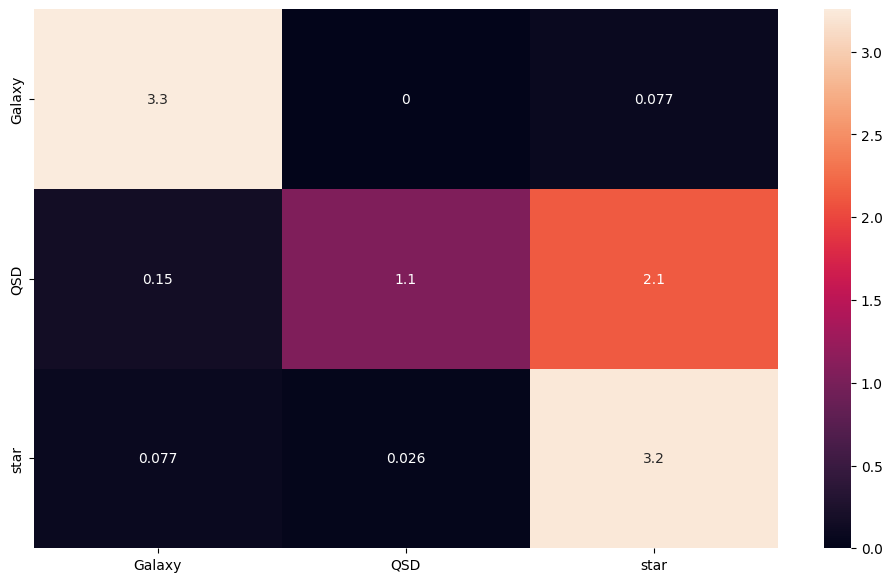

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []
correct = 0
total = 0

# iterate over test data
for inputs, labels in testset:
        output = model(inputs.view(-1, 3*128 * 128)) # Feed Network with flatten x

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        # output of nn is batchsize*number of classes, we want only the highest valued class for each data(row)
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
# constant for classes
classes = ('Galaxy', 'QSD', 'star')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [48]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Galaxy       0.93      0.98      0.95       130
         QSD       0.98      0.32      0.48       130
        star       0.59      0.97      0.74       130

    accuracy                           0.75       390
   macro avg       0.83      0.75      0.72       390
weighted avg       0.83      0.75      0.72       390

